## Estimate AWS channel TBs from ARTS output

In [1]:
import numpy as np
import xarray
import glob
import os
import matplotlib.pyplot as plt
from Channel_TB import get_BT, interpolate_spline, calculate_polarisations, get_channel_BT

Read arts output

In [2]:
files_clearsky = glob.glob(os.path.expanduser('~/Dendrite/Projects/AWS-325GHz/AWS_m30_p30/c_of_*_clearsky.nc'))

files_allsky = [files_clearsky[i].replace('_clearsky.nc', '.nc') for i in range(len(files_clearsky))]


Read all orbitwise ARTS output in `files_clearky` or `files_allsky` into a xarray 

In [3]:
BT = get_BT([files_clearsky[4]])
print ('------')
BT_A = get_BT([files_allsky[4]])

1
------
1


#### Compute the polarisations from Stokes elements, the result is a xarray with following dimensions:

    TB = xarray.DataArray(TB[cases, nviews, nchannels, polarisation],
                     dims=('cases', 'atm_views', 'channels', 'polarisation'),
                    coords={'cases': np.arange(0, cases, 1),
                            'atm_views' : atm_views,
                            'channels' : channels,
                            'polarisation' : ['H', 'V']})


In [4]:
no_channels = 18
TB_all = calculate_polarisations(BT_A, no_channels)

#### Subset `TB_all` into `TB`, for the atm_views and polarisation

In [5]:
atm_views = [135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0, 175.0, 180.0] 

itheta = 9
P = 0

TB = TB_all[:, itheta, :, P]
TB

<xarray.DataArray (cases: 621, channels: 18)>
array([[241.08201599, 276.38299561, 269.5199585 , ..., 259.46194458,
        262.27127075, 263.76849365],
       [238.99276733, 276.53793335, 269.74627686, ..., 259.61807251,
        262.44607544, 263.95281982],
       [238.77656555, 276.6612854 , 269.9395752 , ..., 259.77270508,
        262.61819458, 264.13299561],
       ...,
       [220.23934937, 279.00881958, 278.74935913, ..., 268.83901978,
        271.48220825, 272.97930908],
       [220.03089905, 278.84506226, 278.69107056, ..., 268.73312378,
        271.39529419, 272.90286255],
       [219.824646  , 278.68130493, 278.63220215, ..., 268.62747192,
        271.30841064, 272.82629395]])
Coordinates:
  * cases         (cases) int64 0 1 2 3 4 5 6 7 ... 614 615 616 617 618 619 620
    atm_views     float64 180.0
  * channels      (channels) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
    polarisation  <U1 'H'

#### List of all monochromatic channels simulated from ARTS

In [6]:
channels = np.array([89.0000,
  165.5000,
  175.8110,
  177.4360,
  179.0610,
  180.6860,
  182.3110,
  229.0000,
  316.6500,
  318.5250,
  320.4000,
  322.2750,
  324.1500,
  326.1500,
  328.0250,
  329.9000,
  331.7750,
  333.6500])*1e9


##### Window Channels 

In [7]:
index = np.squeeze(np.argwhere(channels == 89e9))
TB_89 = TB[:, index]

index = np.squeeze(np.argwhere(channels ==165.5e9))
TB_166 = TB[:, index]

index = np.squeeze(np.argwhere(channels == 229e9))
TB_229 = TB[:, index]


#### Interpolate 183GHz channel to a finer grid

In [8]:
index = np.squeeze(np.argwhere((channels > 170e9) & (channels < 183e9)))
TB_183 = TB[:, index]

channels_183 = np.array([176.311, 178.811, 180.311, 181.511, 182.311])*1e9
bandwidth_183 = np.array([2000, 2000, 1000, 1000, 500])*1e6

channels_183_fine = np.arange(channels_183.min()-bandwidth_183[0]/2., 
                              channels_183.max()+bandwidth_183[4]/2., 5e6)



TB_183_fine = interpolate_spline(TB[:, index], channels[index], channels_183_fine)

#### 3 option Channel 325.15GHz

In [9]:
bandwidth_325 = np.array([3000, 2500, 1200])*1e6
channels_325l = np.array((325.15e9 - np.array([6.50,
                                            3.55,
                                            1.60])*1e9))

channels_325u = np.array((325.15e9 + np.array([6.50,
                                            3.55,
                                            1.60])*1e9))

#### Interpolate 325 GHz - low channel to a finer grid

In [10]:
index = np.squeeze(np.argwhere((channels > 300e9) & (channels < 325.15e9)))

channels_325l_fine = np.arange(channels_325l.min()-bandwidth_325[0]/2.0, 
                               channels_325l.max()+bandwidth_325[2]/2.0, 5e6)

TB_325l_fine = interpolate_spline(TB[:, index], channels[index], channels_325l_fine)


#### Interpolate 325GHz-upper channel to a finer grid

In [11]:
index = np.squeeze(np.argwhere((channels > 325e9) & (channels < 340e9)))



channels_325u_fine = np.arange(channels_325u.min()-bandwidth_325[2]/2., 
                               channels_325u.max()+bandwidth_325[0]/2., 5e6)

TB_325u_fine = interpolate_spline(TB[:, index], channels[index], channels_325u_fine)


#### Form AWS channel TBs from the interpolated values   

In [12]:
TB_325l = get_channel_BT(TB_325l_fine, channels_325l_fine, channels_325l, bandwidth_325)

TB_325u = get_channel_BT(TB_325u_fine, channels_325u_fine, channels_325u, bandwidth_325)


In [13]:
TB_325 = (TB_325l + TB_325u)/2

In [14]:
TB_183 = get_channel_BT(TB_183_fine, channels_183_fine, channels_183 , bandwidth_183)


#### Define a new xarray `TB` with all the AWS channels


In [15]:
C = np.stack((TB_89, 
                    TB_166,
                    TB_183[0,:], TB_183[1, :], TB_183[2, :], TB_183[3, :], TB_183[4, :],
                    TB_229,
                    TB_325[0, :], TB_325[1, :], TB_325[2, :] ))

channels = np.array(['C21','C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C4X', 'C41', 'C42', 'C43'])
cases = np.arange(0, C[1].shape[0], 1)
TB_AWS = xarray.DataArray(C, coords = [channels, cases], dims = ['channels', 'cases'], name = 'TB')
TB_AWS.to_netcdf('TB.nc', 'w')

Write interpolated TBs to netcdf file

In [16]:
#channels = channels_183_fine
#cases = np.arange(0, 621, 1)
#interpolated_TB = xarray.DataArray(TB_183_fine, coords = [cases, channels],
#                                       dims = ['cases', 'channels'], name = 'interpolated_TB_183')

#interpolated_TB.to_netcdf('183_fine.nc', 'w')


#channels = channels_325l_fine
#cases = np.arange(0, TB_325l_fine.shape[0], 1)
#interpolated_TB = xarray.DataArray(TB_325l_fine, coords = [cases, channels],
#                                       dims = ['cases', 'channels'], name = 'interpolated_TB_325l')

#interpolated_TB.to_netcdf('325l_fine.nc', 'w')

#print (TB_325l_fine.shape)
#channels = channels_325u_fine
#cases = np.arange(0, TB_325u_fine.shape[0], 1)
#interpolated_TB = xarray.DataArray(TB_325u_fine, coords = [cases, channels],
#                                       dims = ['cases', 'channels'], name = 'interpolated_TB_325u')

#interpolated_TB.to_netcdf('325u_fine.nc', 'w')

####  scatter density plot between two channels

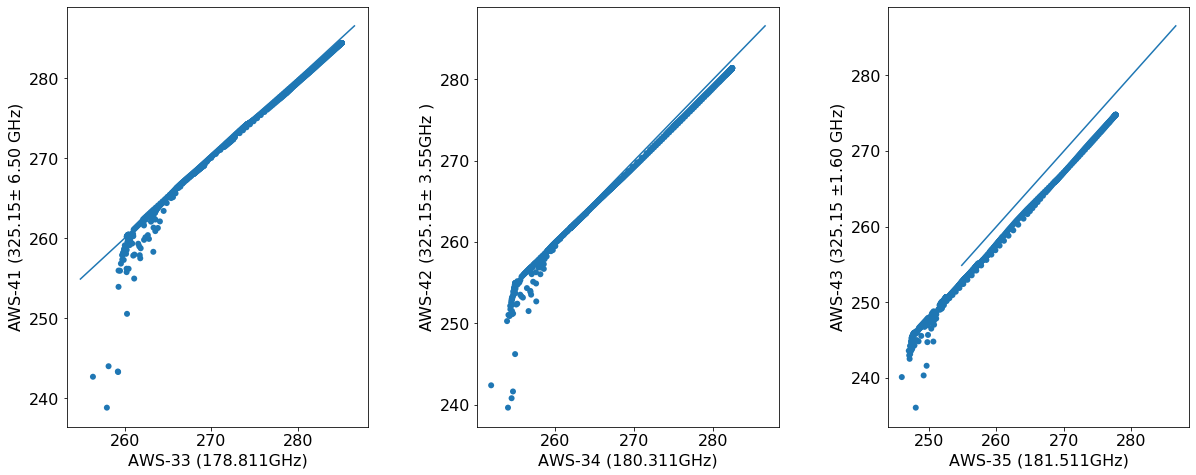

In [17]:
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 8))
fig.tight_layout(pad=4.0)
#C33, C41, z = density(C33, C41)
ax1.scatter(TB_AWS[3, :], TB_AWS[8, :], edgecolor='')
ax1.set_xlabel('AWS-33 (178.811GHz)', fontsize = 16)
ax1.set_ylabel('AWS-41 (325.15$\pm$ 6.50 GHz)', fontsize = 16)
#ax1.set_xlim(240, 290)
#ax1.set_ylim(240, 290)
#ax1.set_xlim(75, 290)
#ax1.set_ylim(75, 290)

#C34, C42, z = density(C34, C42)
ax2.scatter(TB_AWS[4, :], TB_AWS[9,:], edgecolor='')
ax2.set_xlabel('AWS-34 (180.311GHz)', fontsize = 16)
ax2.set_ylabel('AWS-42 (325.15$\pm$ 3.55GHz )', fontsize = 16)
#ax2.set_xlim(240, 290)
#ax2.set_ylim(240, 290)
#ax2.set_xlim(75, 290)
#ax2.set_ylim(75, 290)

#C35, C43, z = density(C35, C43)
ax3.scatter(TB_AWS[5, :], TB_AWS[10, :],edgecolor='')
ax3.set_xlabel('AWS-35 (181.511GHz)', fontsize = 16)
ax3.set_ylabel('AWS-43 (325.15 $\pm $1.60 GHz)', fontsize = 16)
#ax3.set_xlim(240, 290)
#ax3.set_ylim(240, 290)
#ax3.set_xlim(75, 290)
#ax3.set_ylim(75, 290)
    
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x)
ax2.plot(x, x)
ax3.plot(x, x)
